## Villin

In [1]:
from md_intrinsic_dimension import intrinsic_dimension, section_id, secondary_structure_id
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import matplotlib as mpl
import seaborn as sns
import logging
from moleculekit.molecule import Molecule
from itertools import product

#build personalised cmap
colors = mpl.colors.ListedColormap(
    name="discrete-bicolor",
    colors=["#e9ff99","#ceff29", "#A5CC21", "#C099F3", "#6100e0", "#4E00B3"])

cmap = plt.get_cmap('jet') 
#set font dimension
plt.rcParams.update({
	'axes.titlesize': 13,
	'axes.labelsize': 13,
	'xtick.labelsize': 11,
	'ytick.labelsize': 11,
	'legend.fontsize': 11,
	'legend.title_fontsize': 13,
	'lines.linewidth' : 1,
	'lines.markersize': 8,
})

In [ ]:
data = []
states = ['u0','u1', 'u2', 'f0', 'f1', 'f2'] 
#estimators = ['CorrInt','lPCA', 'MADA', 'MiND_ML','MLE', 'MOM', 'TLE', 'TwoNN']
#estimators = ['MiND_ML']
estimators = ['CorrInt', 'DANCo', 'ESS', 'FisherS','KNN', 'lPCA', 'MADA', 'MiND_ML', 'MLE', 'MOM', 'TLE', 'TwoNN']
projection_method = 'Dihedrals'  # or 'Distances'
projection_kwargs = {'skip': 3}

for estimator, state in product(estimators, states):
    if estimator == 'MiND_ML':
         mean_all, mean_last, local_id = intrinsic_dimension(topology='examples/villin/2f4k.pdb', trajectory=f'examples/villin/2f4k_{state}.xtc', projection_method=projection_method, projection_kwargs = projection_kwargs,id_method='local',id_kwargs={'estimator': estimator, 'D': 100}, verbose=True)
    else:    
         mean_all, mean_last, local_id = intrinsic_dimension(topology='examples/villin/2f4k.pdb', trajectory=f'examples/villin/2f4k_{state}.xtc', projection_method=projection_method, projection_kwargs = projection_kwargs,id_method='local',id_kwargs={'estimator': estimator}, verbose=True)
	
    data.append({'trajectory': state,
	  'estimator': estimator,
	  'mean_all': mean_all,
	  'mean_last': mean_last,
      'local_id': local_id})
data = pd.DataFrame(data)
data["folded"] = data["trajectory"].str.startswith("f")

data.to_csv(f'villin_estimators_{projection_method}.csv')

In [4]:
data

,Unnamed: 0,trajectory,estimator,mean_all,mean_last,local_id,folded
0,0,u0,CorrInt,5.489110,5.528393,[6.62455851 7.47444338 6.71764305 ... 4.774433...,False
1,1,u1,CorrInt,6.353653,7.130722,[6.69062472 6.9267023 6.78084647 ... 6.999720...,False
2,2,u2,CorrInt,5.390564,5.114127,[5.68116216 5.64204066 5.93674181 ... 5.540702...,False
3,3,f0,CorrInt,11.308453,12.530170,[13.10120012 10.12257329 13.83708742 ... 6.76...,True
4,4,f1,CorrInt,8.434294,10.053049,[11.72512016 11.83943511 5.19411971 ... 11.44...,True
...,...,...,...,...,...,...,...
67,67,u1,TwoNN,7.042565,6.498846,[7.00303813 7.22446479 6.94335661 ... 6.451373...,False
68,68,u2,TwoNN,8.973540,9.543827,[9.37611638 9.27891695 8.46373673 ... 8.609401...,False
69,69,f0,TwoNN,22.126791,23.190137,[23.76022735 20.41187321 23.93964517 ... 17.22...,True
70,70,f1,TwoNN,19.782364,22.606750,[22.76371418 23.40457219 15.73476166 ... 22.55...,True


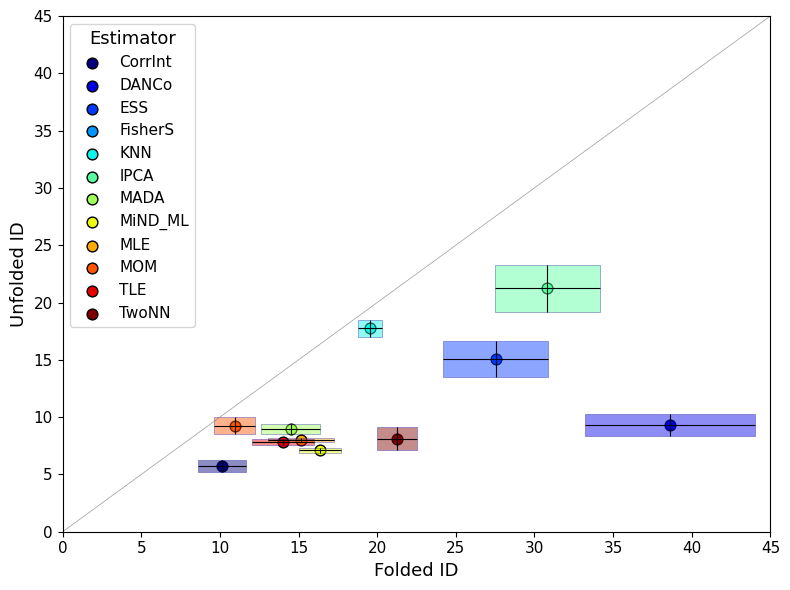

In [11]:
data = pd.read_csv('../extra/villin_estimators_dihedrals.csv')


plt.figure(figsize=(8,6))
ax = plt.gca()
group=data.groupby('trajectory')
estimators = data['estimator'].unique()

for i, estimator in enumerate(estimators):
    color = cmap(i / (len(estimators) - 1)) 
    estimator_data = data[data['estimator'] == estimator]
    folded_values = estimator_data[estimator_data['folded']]['mean_all']
    unfolded_values = estimator_data[~estimator_data['folded']]['mean_all']
    x_mean = folded_values.mean()
    y_mean = unfolded_values.mean()
    x_std = folded_values.std()
    y_std = unfolded_values.std()

    ax.errorbar(x_mean, y_mean, xerr=x_std, yerr=y_std, fmt='none', ecolor='black', elinewidth=0.8,)
    ax.scatter(x_mean, y_mean,facecolors=color, edgecolors='black',s=60, label=estimator)

    rect = patches.Rectangle((x_mean - x_std, y_mean - y_std), 2 * x_std, 2 * y_std)
    pc = PatchCollection([rect],  facecolor=color,alpha=0.45,edgecolor=cmap(i),linewidth=0.5,linestyle="-")
    ax.add_collection(pc)
min_val = data['mean_all'].min() - 0.5
max_val = data['mean_all'].max() + 0.5
#plt.axline((10, 10), (30, 30), lw=0.5, color='black', alpha=0.8)
plt.axline((5, 5), (12, 12), lw=0.5, color='grey', alpha=0.8)
plt.xlabel('Folded ID')
plt.ylabel('Unfolded ID')
plt.legend( loc='best', title= 'Estimator')

# Set equal axis limits for better visualization
plt.ylim(0, 45)
plt.xlim(0, 45)

plt.tight_layout()
plt.savefig('../extra/villin_foldedvsunfolded_std_dihedrals.png', dpi=300, bbox_inches='tight')
plt.show()


In [22]:
#data['local_id'][0]

values = data['local_id'][0].strip('[]').split()
arr = np.array(values, dtype=float)
std_val = np.std(arr)
std_val

ValueError: could not convert string to float: '...'

TypeError: the resolved dtypes are not compatible with add.reduce. Resolved (dtype('<U71'), dtype('<U71'), dtype('<U142'))

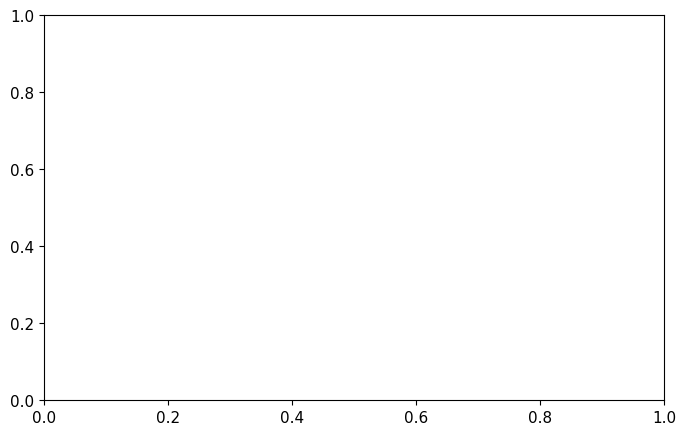

In [12]:
estimators = data["estimator"].unique()
states = data["trajectory"].unique()

fig, ax = plt.subplots(figsize=(8, 5))

shift_amount = 0.05
n_traj = len(states)
shifts = np.linspace(-shift_amount, shift_amount, n_traj)
shift_map = dict(zip(states, shifts))

for _, row in data.iterrows():
    est_idx = np.where(estimators == row["estimator"])[0][0]

    # assign a slight offset depending on trajectory
    x = est_idx + shift_map[row["trajectory"]]
    color_idx = np.where(states == row["trajectory"])[0][0] 

    mean_val = row["mean_all"]
    local_vals = row["local_id"]
 
    # 1) Scatter only
    # ax.scatter(x, mean_val, color=color,edgecolor="black", alpha=0.8, s=80, label = traj)

    # 2) Error bars with std
    std_val = np.std(local_vals)
    ax.errorbar(x, mean_val, yerr=std_val, fmt='o', color=colors.colors[color_idx],ecolor='black', capsize=5,markersize=8, markeredgecolor='black', alpha=0.8, label = row["trajectory"])

    # 3) Error bars with min/max
    # ymin, ymax = np.min(local_vals), np.max(local_vals)
    # ax.errorbar(x, mean_val, yerr=[[mean_val - ymin], [ymax - mean_val]],fmt='o', color=color, ecolor=color_map[row["trajectory"]],capsize=5, markersize=8, markeredgecolor='black', alpha=0.8, label = traj)

ax.set_xticks(range(len(estimators)))
ax.set_xticklabels(estimators, rotation=45, ha="right")
ax.set_ylabel("ID")
ax.set_xlabel("Estimator")
handles = [
    plt.Line2D([0],[0], marker='o', color='w',
               markerfacecolor=colors.colors[i], markeredgecolor='black',
               markersize=8, label=f'{s}')
    for i, s in enumerate(states)
]

plt.legend(handles=handles, title='Trajectory', loc='best')

plt.tight_layout()
plt.savefig('../extra/villin_estimators_std.png', dpi=300)
plt.show()

## NTL9

In [ ]:
data2 = []
states = ['u0','u1', 'u2', 'f0', 'f1', 'f2'] 
#estimators = ['CorrInt','lPCA', 'MADA', 'MiND_ML','MLE', 'MOM', 'TLE', 'TwoNN']
#estimators = ['MiND_ML']
estimators = ['CorrInt', 'DANCo', 'ESS', 'FisherS','KNN', 'lPCA', 'MADA', 'MiND_ML', 'MLE', 'MOM', 'TLE', 'TwoNN']
projection_method = 'Dihedrals'  # or 'Distances'
projection_kwargs = {'skip': 3}


for estimator, state in product(estimators, states):
    if estimator == 'MiND_ML':
         mean_all, mean_last, local_id = intrinsic_dimension(topology='examples/NTL9/ntl9.pdb', trajectory=f'examples/NTL9/ntl9_{state}.xtc', projection_method=projection_method, projection_kwargs = projection_kwargs,id_method='local',id_kwargs={'estimator': estimator, 'D': 100}, verbose=True)
    else:    
         mean_all, mean_last, local_id = intrinsic_dimension(topology='examples/NTL9/ntl9.pdb', trajectory=f'examples/NTL9/ntl9_{state}.xtc', projection_method=projection_method, projection_kwargs = projection_kwargs,id_method='local',id_kwargs={'estimator': estimator}, verbose=True)
	
    data2.append({'trajectory': state,
	  'estimator': estimator,
	  'mean_all': mean_all,
	  'mean_last': mean_last,
      'local_id': local_id})
data2 = pd.dataFrame(data2)
data2["folded"] = data2["trajectory"].str.startswith("f")

data2.to_csv(f'ntl9_estimators_{projection_method}.csv')

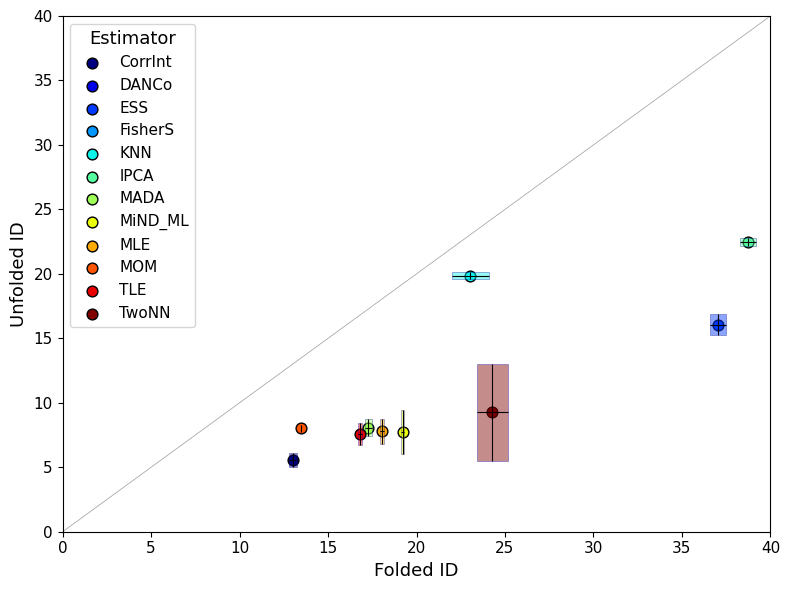

In [16]:
data2 = pd.read_csv('ntl9_estimators_Dihedrals.csv') #va spostato

estimators = data['estimator'].unique()
plt.figure(figsize=(8,6))
ax = plt.gca()
group=data2.groupby('trajectory')

for i, estimator in enumerate(estimators):
    color = cmap(i / (len(estimators) - 1)) 
    estimator_data2 = data2[data2['estimator'] == estimator]
    folded_values = estimator_data2[estimator_data2['folded']]['mean_all']
    unfolded_values = estimator_data2[~estimator_data2['folded']]['mean_all']
    x_mean = folded_values.mean()
    y_mean = unfolded_values.mean()
    x_std = folded_values.std()
    y_std = unfolded_values.std()

    ax.errorbar(x_mean, y_mean, xerr=x_std, yerr=y_std, fmt='none', ecolor='black', elinewidth=0.8,)
    ax.scatter(x_mean, y_mean,facecolors=color, edgecolors='black',s=60, label=estimator)

    rect = patches.Rectangle((x_mean - x_std, y_mean - y_std), 2 * x_std, 2 * y_std)
    pc = PatchCollection([rect],  facecolor=color,alpha=0.45,edgecolor=cmap(i),linewidth=0.5,linestyle="-")
    ax.add_collection(pc)
min_val = data2['mean_all'].min() - 0.5
max_val = data2['mean_all'].max() + 0.5
#plt.axline((10, 10), (30, 30), lw=0.5, color='black', alpha=0.8)
plt.axline((5, 5), (12, 12), lw=0.5, color='grey', alpha=0.8)
plt.xlabel('Folded ID')
plt.ylabel('Unfolded ID')
plt.legend(loc='best', title= 'Estimator')

# Set equal axis limits for better visualization
plt.ylim(0, 40)
plt.xlim(0, 40)

plt.tight_layout()
plt.savefig('../extra/ntl9_foldedvsunfolded_std_dihedrals.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
estimators = data2["estimator"].unique()
states = data2["trajectory"].unique()

fig, ax = plt.subplots(figsize=(8, 5))

shift_amount = 0.05
n_traj = len(states)
shifts = np.linspace(-shift_amount, shift_amount, n_traj)
shift_map = dict(zip(states, shifts))

for _, row in data2.iterrows():
    est_idx = np.where(estimators == row["estimator"])[0][0]

    # assign a slight offset depending on trajectory
    x = est_idx + shift_map[row["trajectory"]]
    color_idx = np.where(states == row["trajectory"])[0][0] 

    mean_val = row["mean_all"]
    local_vals = row["local_id"]
 
    # 1) Scatter only
    # ax.scatter(x, mean_val, color=color,edgecolor="black", alpha=0.8, s=80, label = traj)

    # 2) Error bars with std
    std_val = np.std(local_vals)
    ax.errorbar(x, mean_val, yerr=std_val, fmt='o', color=colors.colors[color_idx],ecolor='black', capsize=5,markersize=8, markeredgecolor='black', alpha=0.8, label = row["trajectory"])

    # 3) Error bars with min/max
    # ymin, ymax = np.min(local_vals), np.max(local_vals)
    # ax.errorbar(x, mean_val, yerr=[[mean_val - ymin], [ymax - mean_val]],fmt='o', color=color, ecolor=color_map[row["trajectory"]],capsize=5, markersize=8, markeredgecolor='black', alpha=0.8, label = traj)

ax.set_xticks(range(len(estimators)))
ax.set_xticklabels(estimators, rotation=45, ha="right")
ax.set_ylabel("ID")
ax.set_xlabel("Estimator")
handles = [
    plt.Line2D([0],[0], marker='o', color='w',
               markerfacecolor=colors.colors[i], markeredgecolor='black',
               markersize=8, label=f'{s}')
    for i, s in enumerate(states)
]

ax.legend(handles=handles, title='Trajectory', bbox_to_anchor=(1.20, 0.5), loc='center left')

plt.tight_layout()
plt.savefig('../extra/ntl9_estimators_std.png', dpi=300)
plt.show()